### Continuity


> Samples are needed for sequence models and transformer models for input


😈 **Task 1:** How does a basic MLP differ from models like RNNs or ARIMA when used for time series forecasting?

😈 **Question 1:** What challenges might arise when feeding sequences into a feedforward model like an MLP?



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96 
# variable_column = ["no2", "temp", "o3", "no", "press"]
variable_column = ["temp"]

In [6]:
# Function to create continous time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, n_past=24, n_future=6):
    X, y = [], []
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
    for i in range(n_past, len(data) - n_future):
        window = data['datetime'].iloc[i - n_past : i + n_future]
        if not (window.diff().iloc[1:] == pd.Timedelta(hours=1)).all():
            continue # only if each step is 1 hour apart

        X.append(data[variable_column].iloc[i - n_past : i].values)
        y.append(data[variable_column].iloc[i : i + n_future].values)
    return np.array(X), np.array(y)

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [ ]:
import pickle
## Processed data .pkl files are also made available for the select stations in URL:
# only temp : https://drive.google.com/drive/folders/197WGFswCLYinkx-48XBMQKILwJQMokd0?usp=sharing

with open("./content/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("./content/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("./content/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("./content/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

## Normalized data csv is also made available for the select stations in URL:
# all 5 varibles: https://drive.google.com/file/d/1ohReYdUgtBFogeAmxghPo3_Qa9RnzxSh/view?usp=drive_link
dataframe = pd.read_csv(r"./content/timeseries_data/normalized_data.csv")
scaler_stats = {col: {'mean': dataframe[col].mean(), 'std': dataframe[col].std()} for col in variable_column}

# Flatten input features
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(variable_column))  # (samples, 24*5)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], len(variable_column))
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1],  len(variable_column))
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],  len(variable_column))


X_train shape: (319325, 336), y_train shape: (319325, 96)
X_test shape: (79832, 336), y_test shape: (79832, 96)


### Forecasting with Simple Neural Network: MLP

> The below snippet uses tensorflow to create a simple

😈 **Task 2:** Try changing the number of input lags used. How does it affect forecasting accuracy?

😈 **Task 3:** Compare results using `no2` vs `o3` as the target variable.


The below cell has sample hyperparameters and activation, loss functions, Modify these values for experimentation


😈 **Task 4:** Modify the activation function to `tanh` or `selu`. How does training performance change?

😈 **Task 5:** Try different optimizers (e.g., SGD, RMSProp) and compare their impact on convergence.

😈 **Question 2:** Why might ReLU not be ideal for all types of time series data?

In [ ]:
## Remember the checkpoints made available are trained with below hyper params
# If changed you will have to retrain loading appropriate inputs like eg. loss
mlp_hidden_units = [64, 32]
mlp_epochs = 5
mlp_batch_size = 16
activation_fn='relu'
mlp_optim = 'adam'
mlp_loss = 'mse'

In [ ]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/drive/folders/1-fkX0xKVcVOTJjBEz6pjl2D19vhjn8rs?usp=drive_link
# and the path needs to be updated to checkpoint_dir below:
checkpoint_dir = "./checkpoint/mlp_model_checkpoint_96/"
os.makedirs(checkpoint_dir, exist_ok=True)

num_variables = 1 #len(variable_column)
mlp_predictions = []
training_histories = {}

for var_idx in range(num_variables):
    print(f"\nTraining model for variable {var_idx + 1}/{num_variables}")

    X_train_single = X_train[:, :, var_idx]  # Shape: (samples, context_window)
    y_train_single = y_train[:, :, var_idx]  # Shape: (samples, pred_horizon)
    X_test_single = X_test[:, :, var_idx]    # Shape: (samples, context_window)

    y_train_single = y_train_single.reshape(y_train_single.shape[0], -1)

    # Model checkpointing
    checkpoint_path = os.path.join(checkpoint_dir, f"mlp_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {var_idx + 1}")
        mlp_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {var_idx + 1}")

        # Build MLP model
        mlp_model = Sequential([
            Input(shape=(X_train_single.shape[1],)),  # 24 timesteps (context window)
            Dense(mlp_hidden_units[0], activation=activation_fn)
        ])

        for units in mlp_hidden_units[1:]:
            mlp_model.add(Dense(units, activation=activation_fn))

        mlp_model.add(Dense(y_train_single.shape[1]))  # 6 timesteps (pred horizon)
        mlp_model.compile(optimizer=mlp_optim, loss=mlp_loss)

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        # Train model
        training = mlp_model.fit(
            X_train_single, y_train_single,
            epochs=mlp_epochs, batch_size=mlp_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )
        training_histories[var_idx] = training.history

    y_pred_single = mlp_model.predict(X_test_single)
    mlp_predictions.append(y_pred_single)

mlp_predictions = np.concatenate(mlp_predictions, axis=-1).reshape(y_test.shape[0], prediction_horizon, num_variables)  # Shape: (samples, pred hor, 5)
y_pred_single = y_pred_single.reshape(y_pred_single.shape[0], prediction_horizon, 1)



Training model for variable 1/1
Loading existing model for variable 1
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [18]:
# Evaluate
y_test_reshaped = y_test.reshape(y_test.shape[0], prediction_horizon, num_variables) ## depending on
y_test = y_test_reshaped[:, :, var_idx]
y_pred = mlp_predictions[:, :, var_idx]

# Evaluate the model for this variable
evaluate_model(y_test, y_pred)

RMSE: 0.4454


np.float64(0.4454030609797411)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


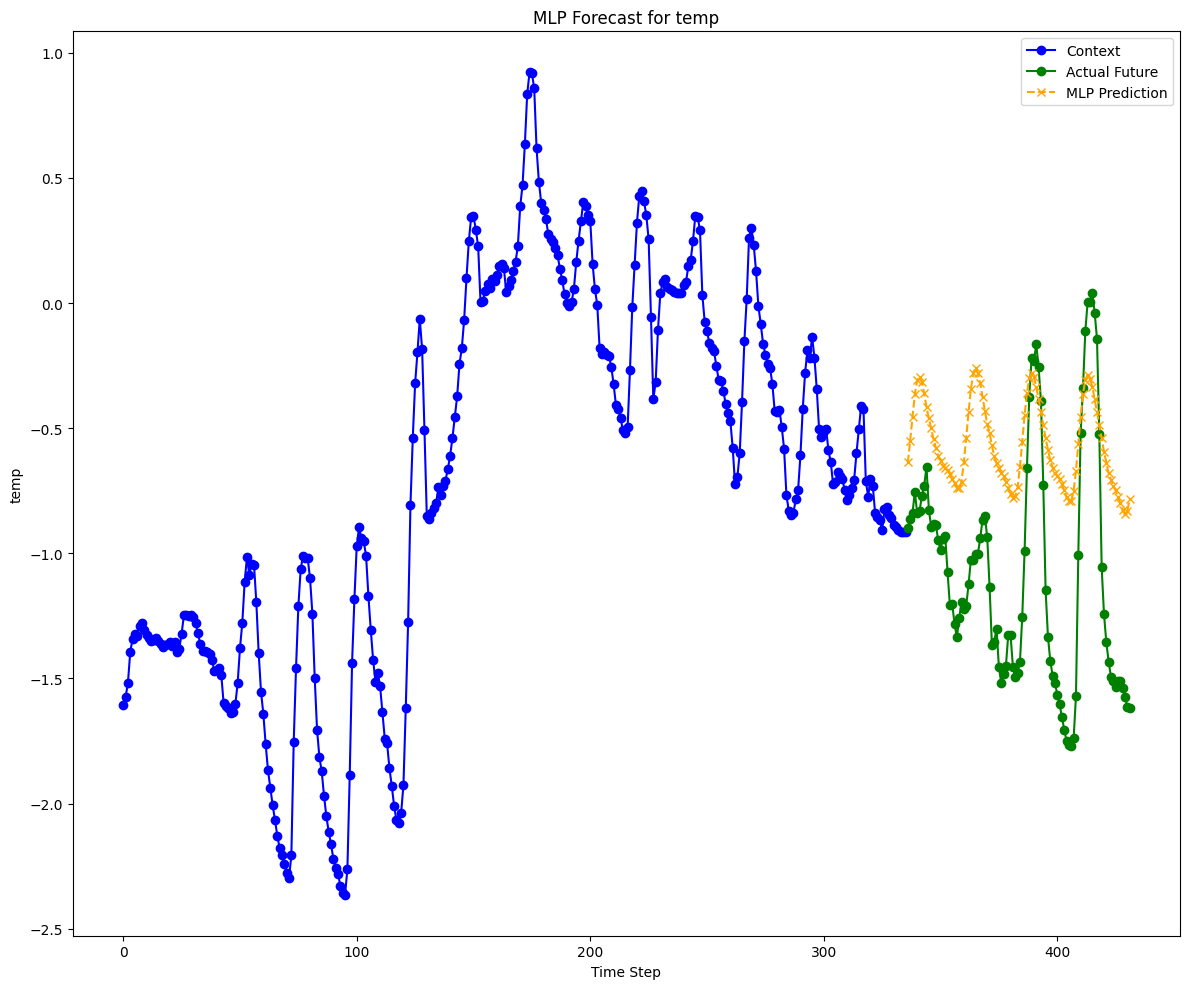

In [22]:
plt.figure(figsize=(12, 10))

for variable_idx in range(num_variables):
    mlp_model = load_model(
        os.path.join(checkpoint_dir, f"mlp_var{variable_idx}.h5"),
        custom_objects={"mse": MeanSquaredError()}
    )

    # Last sample
    sample_idx = -1
    X_test_sample = X_test[sample_idx, :, variable_idx]
    y_test_sample = y_test[sample_idx, :, variable_idx]

    # Predict
    mlp_pred_sample = mlp_model.predict(X_test_sample.reshape(1, -1)).flatten()

    # Inverse scale 
    context = X_test_sample * scaler_stats[variable_column[variable_idx]]['std'] + scaler_stats[variable_column[variable_idx]]['mean']
    actual_future = y_test_sample * scaler_stats[variable_column[variable_idx]]['std'] + scaler_stats[variable_column[variable_idx]]['mean']
    predicted_future = mlp_pred_sample * scaler_stats[variable_column[variable_idx]]['std'] + scaler_stats[variable_column[variable_idx]]['mean']

    # Plot
    plt.subplot(num_variables, 1, variable_idx + 1)

    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), actual_future, label="Actual Future", color="green", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), predicted_future, label="MLP Prediction", linestyle="--", color="orange", marker="x")

    plt.title(f"MLP Forecast for {variable_column[variable_idx]}")
    plt.xlabel("Time Step")
    plt.ylabel(variable_column[variable_idx])
    plt.legend()

plt.tight_layout()
plt.show()
